In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from datetime import datetime

#Torch-related imports
import torch
import torch.distributions as D
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Function

#Model-specific imports
from SBM_SDE import *
from obs_and_flow import *
from training import *
from plotting import *

#PyTorch settings
torch.manual_seed(0)
print('cuda device available?: ', torch.cuda.is_available())
active_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

#Neural SDE parameters
dt_flow = 0.1
t = 5000 #In hours.
n = int(t / dt_flow) + 1
t_span = np.linspace(0, t, n)
t_span_tensor = torch.reshape(torch.Tensor(t_span), [1, n, 1]).to(active_device) #T_span needs to be converted to tensor object. Additionally, facilitates conversion of I_S and I_D to tensor objects.
state_dim_SCON = 3 #Not including CO2 in STATE_DIM, because CO2 is an observation.
state_dim_SAWB = 4 #Not including CO2 in STATE_DIM, because CO2 is an observation.

#SBM temperature forcing parameters
temp_ref = 283
temp_rise = 5 #High estimate of 5 celsius temperature rise by 2100.

#Training parameters
niter = 4
piter = 0
pretrain_lr = 1e-2 #Norm regularization learning rate
train_lr = 1e-3 #ELBO learning rate
batch_size = 3 #3 - number needed to fit UCI HPC3 RAM requirements with 16 GB RAM.
eval_batch_size = 10 
obs_error_scale = 0.1 #Observation (y) standard deviation
num_layers = 5 #5 - number needed to fit UCI HPC3 RAM requirements with 16 GB RAM.

#SBM prior means
#System parameters from deterministic CON model
u_M = 0.0009
a_SD = 0.5
a_DS = 0.5
a_M = 0.5
a_MSC = 0.5
k_S_ref = 0.0001
k_D_ref = 0.001
k_M_ref = 0.00022
Ea_S = 55
Ea_D = 48
Ea_M = 48

#SCON diffusion matrix parameters
c_SOC = 0.05
c_DOC = 0.001
c_MBC = 0.0005

SCON_C_params_dict = {'u_M': u_M, 'a_SD': a_SD, 'a_DS': a_DS, 'a_M': a_M, 'a_MSC': a_MSC, 'k_S_ref': k_S_ref, 'k_D_ref': k_D_ref, 'k_M_ref': k_M_ref, 'Ea_S': Ea_S, 'Ea_D': Ea_D, 'Ea_M': Ea_M, 'c_SOC': c_SOC, 'c_DOC': c_DOC, 'c_MBC': c_MBC}

#Initial condition prior means
x0_SCON = [65, 0.4, 2.5]
x0_SCON_tensor = torch.tensor(x0_SCON).to(active_device)
x0_prior_SCON = D.multivariate_normal.MultivariateNormal(x0_SCON_tensor,
                                                         scale_tril = torch.eye(state_dim_SCON).to(active_device) * obs_error_scale * x0_SCON_tensor)

#Generate exogenous input vectors.
#Obtain temperature forcing function.
temp_tensor = temp_gen(t_span_tensor, temp_ref, temp_rise).to(active_device)

#Obtain SOC and DOC pool litter input vectors for use in flow SDE functions.
i_s_tensor = i_s(t_span_tensor).to(active_device) #Exogenous SOC input function
i_d_tensor = i_d(t_span_tensor).to(active_device) #Exogenous DOC input function

#Generate observation model.
obs_times, obs_means_noCO2, obs_error = csv_to_obs_df('y_from_x_t_5000_dt_0-01.csv', state_dim_SCON, t, obs_error_scale)
obs_model_noCO2 = ObsModel(active_device, TIMES = obs_times, DT = dt_flow, MU = obs_means_noCO2, SCALE = obs_error).to(active_device) 

#Call training loop function for SCON-C.
net, ELBO_hist = train(active_device, pretrain_lr, train_lr, niter, piter, batch_size, num_layers,
          state_dim_SCON, 'y_from_x_t_5000_dt_0-01.csv', obs_error_scale, t, dt_flow, n, 
          t_span_tensor, i_s_tensor, i_d_tensor, temp_tensor, temp_ref,
          drift_diffusion_SCON_C, x0_prior_SCON, SCON_C_params_dict,
          LEARN_PARAMS = False, LR_DECAY = 0.1, DECAY_STEP_SIZE = 1000, PRINT_EVERY = 50)

#Save net and ELBO files.
now = datetime.now()
now_string = now.strftime("%Y_%m_%d_%H_%M_%S")
torch.save(net, f'net_iter_{niter}_t_{t}_dt_{dt_flow}_{now_string}.pt')
torch.save(ELBO_hist, f'ELBO_iter_{niter}_t_{t}_dt_{dt_flow}_{now_string}.pt')


Train Diffusion:   0%|          | 0/4 [00:00<?, ?it/s]

cuda device available?:  False



Train Diffusion: 100%|██████████| 4/4 [07:12<00:00, 108.23s/it]


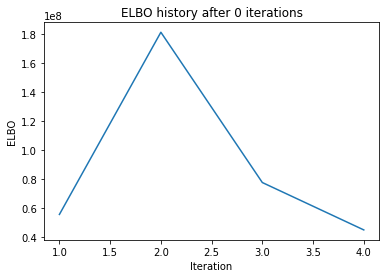

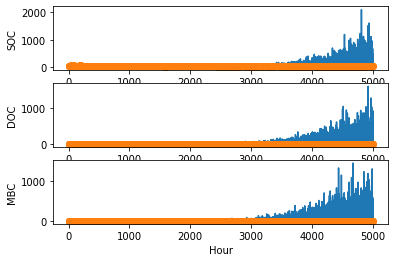

In [2]:
#Plot training results and ELBO history.
net.eval()
x, _ = net(eval_batch_size)

plot_elbo(ELBO_hist, niter, t, dt_flow, batch_size, eval_batch_size, num_layers)
plot_states_post(x, obs_model_noCO2, niter, t, dt_flow, batch_size, eval_batch_size, num_layers)